# A Large-Scale CT and PET/CT Dataset for Lung Cancer Diagnosis (Lung-PET-CT-Dx) https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70224216

# Импорт

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
# import torch.nn.functional as F
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models

In [3]:
!pip install pydicom
from pydicom import dcmread

     |████████████████████████████████| 2.0 MB 5.4 MB/s 


# Функции для просмотра изображений

In [4]:
def show_img_with_info(img, title=''):
  plt.imshow(img)
  plt.title(title)
  plt.axis('off')
  plt.show()
  # print(img.shape)
  print(type(img))
  print(f'dtype: {img.dtype}')

In [51]:
def show_img(img, title=''):
  plt.imshow(img)
  plt.title(title)
  plt.axis('off')
  plt.show()

In [5]:
def show_img_label_info(dataset, idx, title=''):
  img, label = dataset[idx]
  print(f"Label: {dataset.classes[label]} ({str(label)})")
  show_img_with_info(torch.squeeze(img), title)
  print(img.shape)

In [6]:
def show_history(history):
    step = 1 # через сколько эпох выводиться статистика
    plt.plot([i for i in range(step, len(history['acc'])*step+1, step)], history['acc'], '-x', 
         label='Train score')
    plt.plot([i for i in range(step, len(history['val_acc'])*step+1, step)], history['val_acc'], '-x',
         label='Val score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Score vs. No. of epochs');
    plt.legend()
    plt.show()

# Загрузка и просмотр датасета

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [9]:
data_dir = '/content/gdrive/My Drive/lungCancer_CT'

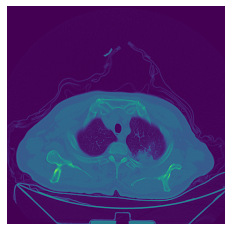

<class 'numpy.ndarray'>
dtype: uint16
(512, 512)


In [ ]:
img_path = data_dir + "/Positive_A/A0001_1-13.dcm"
img = dcmread(img_path).pixel_array
show_img_with_info(img)
print(img.shape)

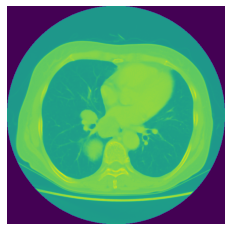

<class 'numpy.ndarray'>
dtype: int16
(512, 512)


In [ ]:
img_path = data_dir + "/Positive_B/B0001_2-033.dcm"
img = dcmread(img_path).pixel_array
show_img_with_info(img)
print(img.shape)

In [ ]:
img_path = data_dir + "/Positive_A/A0020_1-015.dcm"
img = dcmread(img_path).pixel_array
show_img_with_info(img)
print(img.shape)

ValueError: ignored

нужно удалить все снимки, вызывающие ошибку

In [ ]:
from logging import exception
folders = os.listdir(data_dir)
for folder in folders:
  folder_path = os.path.join(data_dir, folder)
  files = os.listdir(folder_path)
  for dicom in files:
    dicom_path = os.path.join(folder_path, dicom)
    try:
      img = dcmread(dicom_path).pixel_array
    except ValueError:
      os.remove(dicom_path)
      print(f"delete: {dicom}")

delete: A0020_1-015.dcm


# Формирование датасета

In [10]:
def dcm_loader(path: str):
  img = dcmread(path).pixel_array
  img = img.astype(np.float32)
  return img

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((256, 256)), 
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
dataset = DatasetFolder(data_dir, loader=dcm_loader, extensions=('.dcm'), transform=transform)

Посмотрим на его классы и примеры картинок

In [ ]:
dataset.classes

['Negative', 'Positive_A', 'Positive_B', 'Positive_E', 'Positive_G']

In [ ]:
from collections import Counter
c = Counter(dataset.targets)

for i, cl in enumerate(dataset.classes):
  print(f"{cl}: {c[i]}")

Negative: 1000
Positive_A: 201
Positive_B: 222
Positive_E: 150
Positive_G: 160


label: Negative


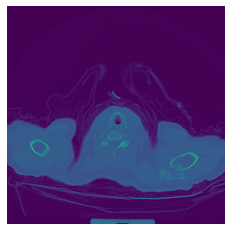

<class 'torch.Tensor'>
dtype: torch.float32
torch.Size([1, 512, 512])


In [ ]:
show_img_label_info(dataset, 0)

label: Negative


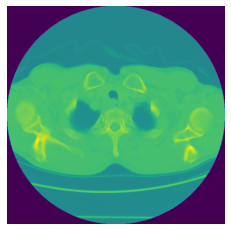

<class 'torch.Tensor'>
dtype: torch.float32
torch.Size([1, 512, 512])


In [ ]:
show_img_label_info(dataset, 500)

label: Positive_A


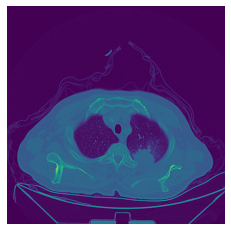

<class 'torch.Tensor'>
dtype: torch.float32
torch.Size([1, 512, 512])


In [ ]:
show_img_label_info(dataset, 1001)

label: Positive_B


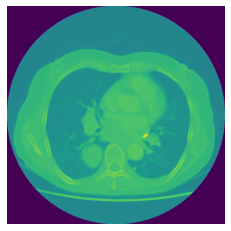

<class 'torch.Tensor'>
dtype: torch.float32
torch.Size([1, 512, 512])


In [ ]:
show_img_label_info(dataset, 1202)

label: Positive_E


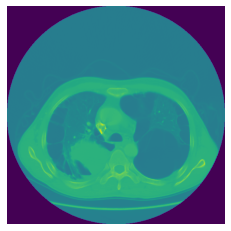

<class 'torch.Tensor'>
dtype: torch.float32
torch.Size([1, 512, 512])


In [ ]:
show_img_label_info(dataset, 1424)

label: Positive_G


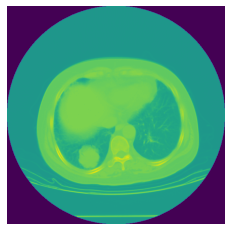

<class 'torch.Tensor'>
dtype: torch.float32
torch.Size([1, 512, 512])


In [ ]:
show_img_label_info(dataset, 1574)

# Очень вероятно слишком сложно, поэтому попробуем перейти к структуре Positive/ Negative

In [12]:
data_dir_disk = '/content/gdrive/My Drive/lungCancer_CT'

In [13]:
data_dir = 'lungCancer_CT2'

In [14]:
os.makedirs(data_dir+'/Positive')
shutil.copytree(data_dir_disk+'/Negative', data_dir+'/Negative')

folders = ['Positive_A', 'Positive_B', 'Positive_E', 'Positive_G']
for folder in folders:
  files_path = os.path.join(data_dir_disk, folder)
  files = os.listdir(files_path)
  for file in files:
    file_path = os.path.join(files_path, file)
    shutil.copyfile(file_path, data_dir+'/Positive/'+file)

In [15]:
dataset = DatasetFolder(data_dir, loader=dcm_loader, extensions=('.dcm'), transform=transform)

Посмотрим на его классы и примеры картинок

In [ ]:
dataset.classes

['Negative', 'Positive']

In [ ]:
from collections import Counter
c = Counter(dataset.targets)

for i, cl in enumerate(dataset.classes):
  print(f"{cl}: {c[i]}")

Negative: 1000
Positive: 732


Label: Positive (1)


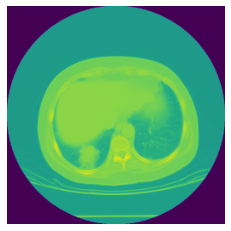

<class 'torch.Tensor'>
dtype: torch.float32
torch.Size([1, 256, 256])


In [ ]:
show_img_label_info(dataset, 1574)

# Разделение датасета и DataLoader

In [16]:
ds_train, ds_val = torch.utils.data.random_split(
        dataset, [1500, 232], generator=torch.Generator().manual_seed(42))

In [17]:
len(ds_train), len(ds_val)

(1500, 232)

In [18]:
batch_size=32
dl_train = DataLoader(ds_train, batch_size, num_workers=2, shuffle=True, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size, num_workers=2, pin_memory=True)

# Функции для обучения

In [19]:
def accuracy(outputs, labels):
    # outputs - это список из списков вероятностей пренадлежности классам. прим: [[0.124, 0.589, 0.287], [...], ..., [...]]
    preds = torch.argmax(outputs, dim=-1) # выбрать наиболее вероятный класс. прим: [1, ...]
    compare = (preds == labels).cpu().numpy().tolist() # сравнить метки с предсказаниями. прим: [True, False, False, ..., True]
    return np.mean(compare) # вернуть количество правильных/количество всех

In [20]:
# проверить качество модели на dataLoader (получить среднии loss и метрику по всем батчам)
def evaluate(model, dloader, loss_fn, metrics_fn=accuracy):
    model.eval()
    with torch.no_grad():
        mean_loss = [] # сюда будем складывать средний лосс по батчам
        accuracy = []
        
        for imgs, labels in dloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            preds = model(imgs)
            loss = loss_fn(preds, labels)
            metrics = metrics_fn(preds, labels)

            mean_loss.append(loss.cpu().numpy()) # добавляем в массив
            accuracy.append(metrics)
        
        return np.mean(mean_loss), np.mean(accuracy)

In [21]:
def fit(num_epochs, model, loss_fn, opt, dl_train, dl_val, metrics_fn=accuracy):
    history = {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs): 
        
        # обучение
        model.train()
        for imgs, labels in dl_train: # train_dl сам перемешается и разделиться при каждой следующей эпохе
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            preds = model(imgs) # предсказываем
            loss = loss_fn(preds, labels) # вычисляем ошибку
            loss.backward() # вычисляем градиент loss_fn по весам и смещениям
            opt.step() # делаем шаг к уменьшению ошибки - обновляем веса и смещения
            opt.zero_grad() # обнуляем градиент, чтобы значения не накапливались
            
            
        # Каждые 1 эпох вывод прогресса и сохранение истории
        if (epoch+1) % 1 == 0:
            acc_train = metrics_fn(preds, labels)
            loss_val, acc_val = evaluate(model, dl_val, loss_fn, metrics_fn)
            
            # вывод статистики
            print('Epoch [{}/{}], loss: {:.4f} - acc: {:.4f}, val_loss: {:.4f} - val_acc: {:.4f}'
                  .format(epoch+1, num_epochs, loss, acc_train, loss_val, acc_val))
            
            # сохранение истории    
            history['acc'].append(acc_train)
            history['val_acc'].append(acc_val)
            history['loss'].append(loss)
            history['val_loss'].append(loss_val)
            
    return history


# Модели

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Гипер параметры
num_epochs = 10
# batch_size = 128
learning_rate = 0.001

cuda


## Resnet18

In [23]:
resnet18 = models.resnet18(pretrained=False)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = nn.Linear(512, 2)
resnet18 = resnet18.to(device)
opt1 = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)

In [33]:
resnet18

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

посмотрим что возвращает модель

In [35]:
# предсказание класса одного изображения
img, _ = dataset[0]
img = img.to(device)
imgb = img.unsqueeze(0)  # батч из 1 изоборажения
label = resnet18(imgb)
label

tensor([[0.6004, 0.2857]], device='cuda:0', grad_fn=<AddmmBackward0>)

качество до обучения

In [36]:
loss, acc = evaluate(resnet18, dl_val, nn.CrossEntropyLoss(), accuracy)
print('loss: {:.4f} - acc: {:.4f}'.format(loss, acc))

loss: 1.3556 - acc: 0.5781


In [37]:
history1 = fit(num_epochs, resnet18, nn.CrossEntropyLoss(), opt1, dl_train, dl_val, accuracy)

Epoch [1/10], loss: 0.4280 - acc: 0.7143, val_loss: 1.1996 - val_acc: 0.5703
Epoch [2/10], loss: 0.3097 - acc: 0.7857, val_loss: 0.8599 - val_acc: 0.6758
Epoch [3/10], loss: 0.1413 - acc: 0.8929, val_loss: 1.1098 - val_acc: 0.6914
Epoch [4/10], loss: 0.2710 - acc: 0.8571, val_loss: 1.1425 - val_acc: 0.6523
Epoch [5/10], loss: 0.0880 - acc: 0.9286, val_loss: 0.7174 - val_acc: 0.7734
Epoch [6/10], loss: 0.2254 - acc: 0.9286, val_loss: 0.2346 - val_acc: 0.9141
Epoch [7/10], loss: 0.2480 - acc: 0.9286, val_loss: 0.1422 - val_acc: 0.9531
Epoch [8/10], loss: 0.0261 - acc: 1.0000, val_loss: 0.9082 - val_acc: 0.6875
Epoch [9/10], loss: 0.1376 - acc: 0.9286, val_loss: 0.3473 - val_acc: 0.8750
Epoch [10/10], loss: 0.0224 - acc: 1.0000, val_loss: 0.1792 - val_acc: 0.9375


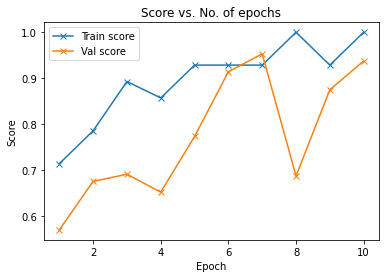

In [38]:
show_history(history1)

In [39]:
torch.save(resnet18.state_dict(), '/content/gdrive/My Drive/resnet18_pos_neg.pth')

## VGG19

In [71]:
vgg19 = models.vgg19(pretrained=False)
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [72]:
vgg19.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg19.classifier[6] = nn.Linear(4096, 2)
vgg19 = vgg19.to(device)
opt2 = torch.optim.Adam(vgg19.parameters(), lr=learning_rate)

качество до обучения

In [73]:
loss, acc = evaluate(vgg19, dl_val, nn.CrossEntropyLoss(), accuracy)
print('loss: {:.4f} - acc: {:.4f}'.format(loss, acc))

loss: 22.3339 - acc: 0.5781


In [74]:
history2 = fit(num_epochs, vgg19, nn.CrossEntropyLoss(), opt2, dl_train, dl_val, accuracy)

Epoch [1/10], loss: 0.7399 - acc: 0.5357, val_loss: 0.6828 - val_acc: 0.5781
Epoch [2/10], loss: 0.6860 - acc: 0.6786, val_loss: 0.6891 - val_acc: 0.5781
Epoch [3/10], loss: 0.6896 - acc: 0.5357, val_loss: 0.6846 - val_acc: 0.5781
Epoch [4/10], loss: 0.7205 - acc: 0.3929, val_loss: 0.6949 - val_acc: 0.5117
Epoch [5/10], loss: 0.6934 - acc: 0.5000, val_loss: 0.6980 - val_acc: 0.5781
Epoch [6/10], loss: 0.6793 - acc: 0.6429, val_loss: 0.6863 - val_acc: 0.5781
Epoch [7/10], loss: 0.6810 - acc: 0.5714, val_loss: 0.6873 - val_acc: 0.5781
Epoch [8/10], loss: 0.6566 - acc: 0.7143, val_loss: 0.6813 - val_acc: 0.5781
Epoch [9/10], loss: 0.7167 - acc: 0.5000, val_loss: 0.6787 - val_acc: 0.5781
Epoch [10/10], loss: 0.6848 - acc: 0.5714, val_loss: 0.6805 - val_acc: 0.5781


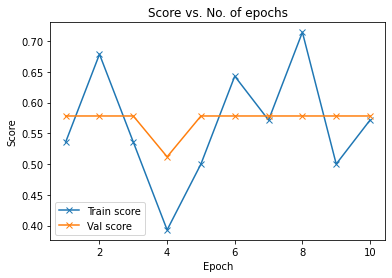

In [75]:
show_history(history2)

# Посмотрим предсказания для конкретных примеров

In [53]:
# предсказание класса одного изображения
def predict_label(img, model):
    img = img.to(device)
    img = img.unsqueeze(0)  # добавить еще одно измерение в начале тензора 1x28x28, делая его тензором 1x1x28x28, который модель рассматривает как пакет, содержащий одно изображение
    preds = model(img)
    _, preds = torch.max(preds, dim=1)
    return preds[0].item()

Label: 0 , Predicted: 0


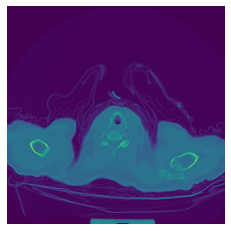

In [54]:
img, label = dataset[0]
print('Label:', label, ', Predicted:', predict_label(img, resnet18))
show_img(torch.squeeze(img))

Label: 0 , Predicted: 0


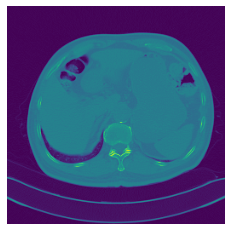

In [55]:
img, label = dataset[734]
print('Label:', label, ', Predicted:', predict_label(img, resnet18))
show_img(torch.squeeze(img))

Label: 0 , Predicted: 0


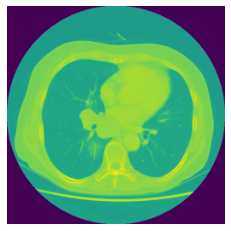

In [56]:
img, label = dataset[423]
print('Label:', label, ', Predicted:', predict_label(img, resnet18))
show_img(torch.squeeze(img))

Label: 1 , Predicted: 0


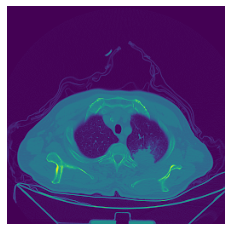

In [57]:
img, label = dataset[1001]
print('Label:', label, ', Predicted:', predict_label(img, resnet18))
show_img(torch.squeeze(img))

Label: 1 , Predicted: 0


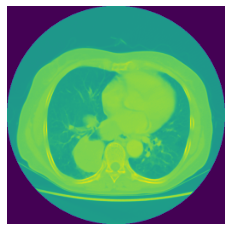

In [60]:
img, label = dataset[1204]
print('Label:', label, ', Predicted:', predict_label(img, resnet18))
show_img(torch.squeeze(img))

Label: 1 , Predicted: 1


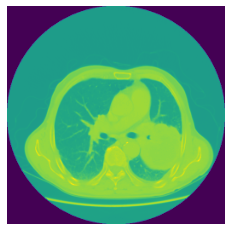

In [68]:
img, label = dataset[1619]
print('Label:', label, ', Predicted:', predict_label(img, resnet18))
show_img(torch.squeeze(img))

Confusion matrix

In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [64]:
def print_confusion_matrix(model):
  y_true = []
  y_preds = []
  for img, label in dataset:
      y_true.append(label)
      pred_item = predict_label(img, model)
      y_preds.append(pred_item)
  print(confusion_matrix(y_true, y_preds))

In [65]:
print_confusion_matrix(resnet18)

[[1000    0]
 [ 720   12]]


те 12 изображений с опухолью, которые предсказались правильно

In [67]:
for i in range(1000, len(dataset)):
  
  img, label = dataset[i]
  p_l = predict_label(img, resnet18)
  if p_l == label:
    print(i)

1319
1393
1397
1408
1409
1410
1411
1491
1590
1591
1619
1620


# Предсказание для изображения не из датасета

загрузим сохраненную, только что обученую модель

In [ ]:
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, 2)

model = model.to(device)
model.load_state_dict(torch.load('/content/gdrive/My Drive/resnet18_pos_neg.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [91]:
img_path = '/content/gdrive/My Drive/lungCancer_CT/Negative/A0001_1-35.dcm'
img = dcm_loader(img_path)
img = transform(img)
predict_label(img, model)

0